<img width="800px" src="./images/football.jpeg"></img>

# <!-- TITLE --> Regression models to estimate the price of a football player
  <!-- AUTHOR : Anthony DAVID -->

## Objectives:

 - Predict the price of a football player from statistics retrieved from the Internet. 
 - Understand the principle and architecture of regression with a dense neural network and a random forest model.

Data are obtained via the notebook **data_scraping.ipynb**. 


## What we're going to do:

 - Recover and clean data
 - Explore and visualize data
 - Prepare data for our machine learning models
 - Build some 'DNN' models with Keras
   - Training and saving the model
   - Restore the saved model
   - Evaluate the model
   - Make predictions
 - Building a Random Forest model with sklearn
   - Training the model
   - Evaluating the model
   - Making predictions


# Imports

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os,sys

from IPython.display import Markdown
from importlib import reload

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
## Removing some warnings appearing when making plots with seaborn.
## The next release on pypi should fix that.
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
### Fonction utilisée pour tracer l'historique de nos modèles

def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig('./figs/'+figname+'.png')
        plt.show()


# Visualization

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head(500)

Rang            Joueur          Poste  Age  Valeur  Buts_2021  \
0       1    Erling Haaland   Avant-Centre   23   180.0         29   
1       2     Kylian Mbappé   Avant-Centre   24   180.0         39   
2       3   Vinicius Junior  Ailier Gauche   23   150.0         22   
3       4       Bukayo Saka   Ailier Droit   21   120.0         12   
4       5    Victor Osimhen   Avant-Centre   24   120.0         18   
..    ...               ...            ...  ...     ...        ...   
495   496     Wilson Isidor   Avant-Centre   22     6.0          8   
496   497      Sorba Thomas   Ailier Droit   24     6.0          3   
497   498       Jacob Brown   Avant-Centre   25     6.0         14   
498   499  Casper Tengstedt   Avant-Centre   23     6.0         30   
499   500   Mostafa Mohamed   Avant-Centre   25     6.0          8   

     Passes_2021  Minutes_2021  Buts_2022  Passes_2022  Minutes_2022  \
0              8          2388         52            9          4131   
1             26          3903         41           10          3564   
2             20          4272         23           21          4759   
3              7          3353         15           11          3744   
4              6          2310         31            5          3021   
..           ...           ...        ...          ...           ...   
495            2          1478         10            5          1436   
496           16          4123          0            8          2850   
497            5          3581          9            2          3070   
498           15          3158          0            1           511   
499            5          1598         11            5          2952   

     Buts_total  Passes_total  Minutes_total  
0           189            45          16189  
1           244           116          24452  
2            73            69          18064  
3            61            58          17186  
4            97            24          13467  
..          ...           ...            ...  
495          44            11           7925  
496          11            29          13030  
497          42            24          16265  
498          73            31           9203  
499          70            20          14530  

[500 rows x 14 columns]

In [5]:
df.columns

Index(['Rang', 'Joueur', 'Poste', 'Age', 'Valeur', 'Buts_2021', 'Passes_2021',
       'Minutes_2021', 'Buts_2022', 'Passes_2022', 'Minutes_2022',
       'Buts_total', 'Passes_total', 'Minutes_total'],
      dtype='object')

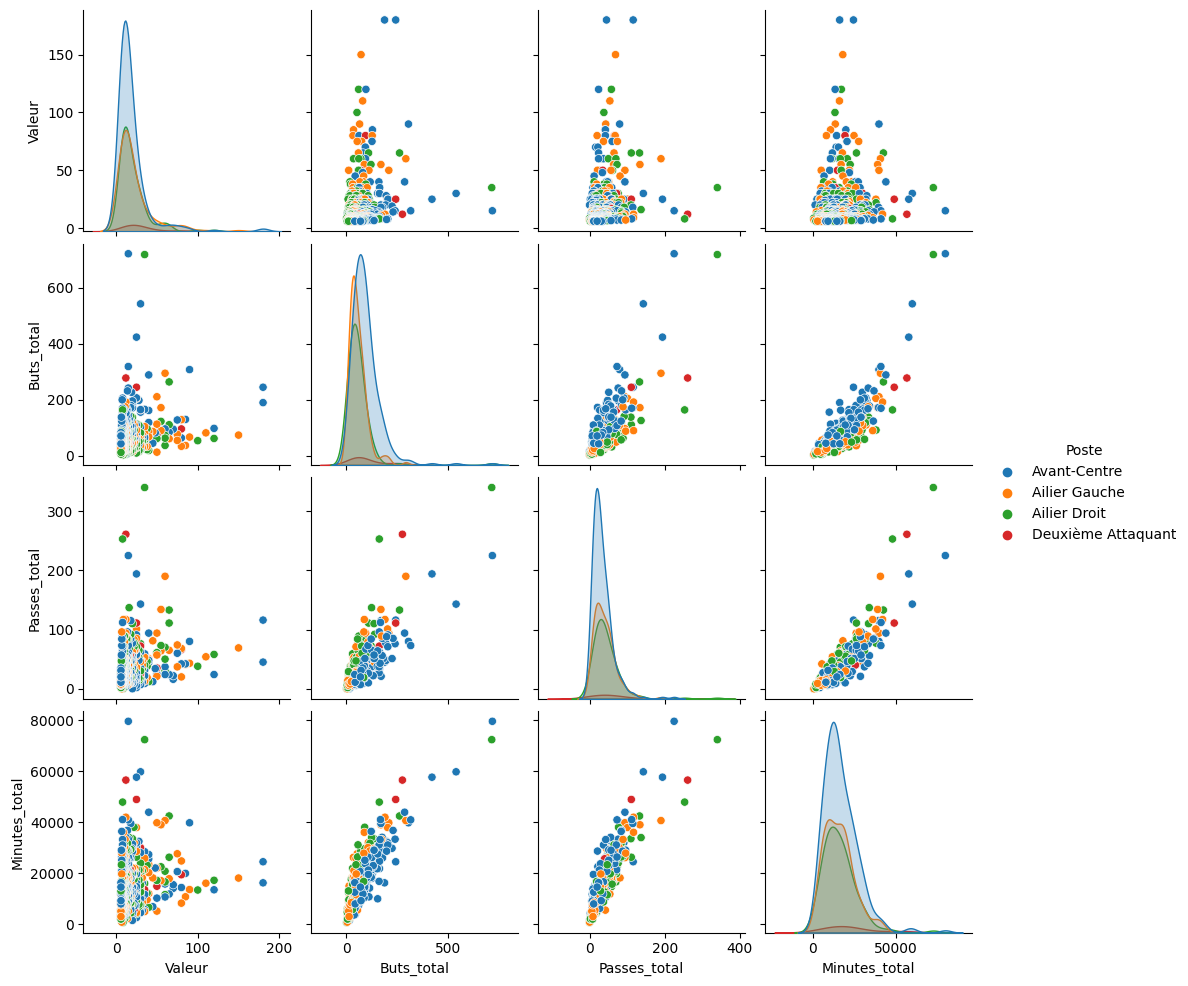

In [6]:
sns.pairplot(df[['Valeur', 'Buts_total', 'Passes_total', 'Minutes_total', 'Poste']], hue='Poste')

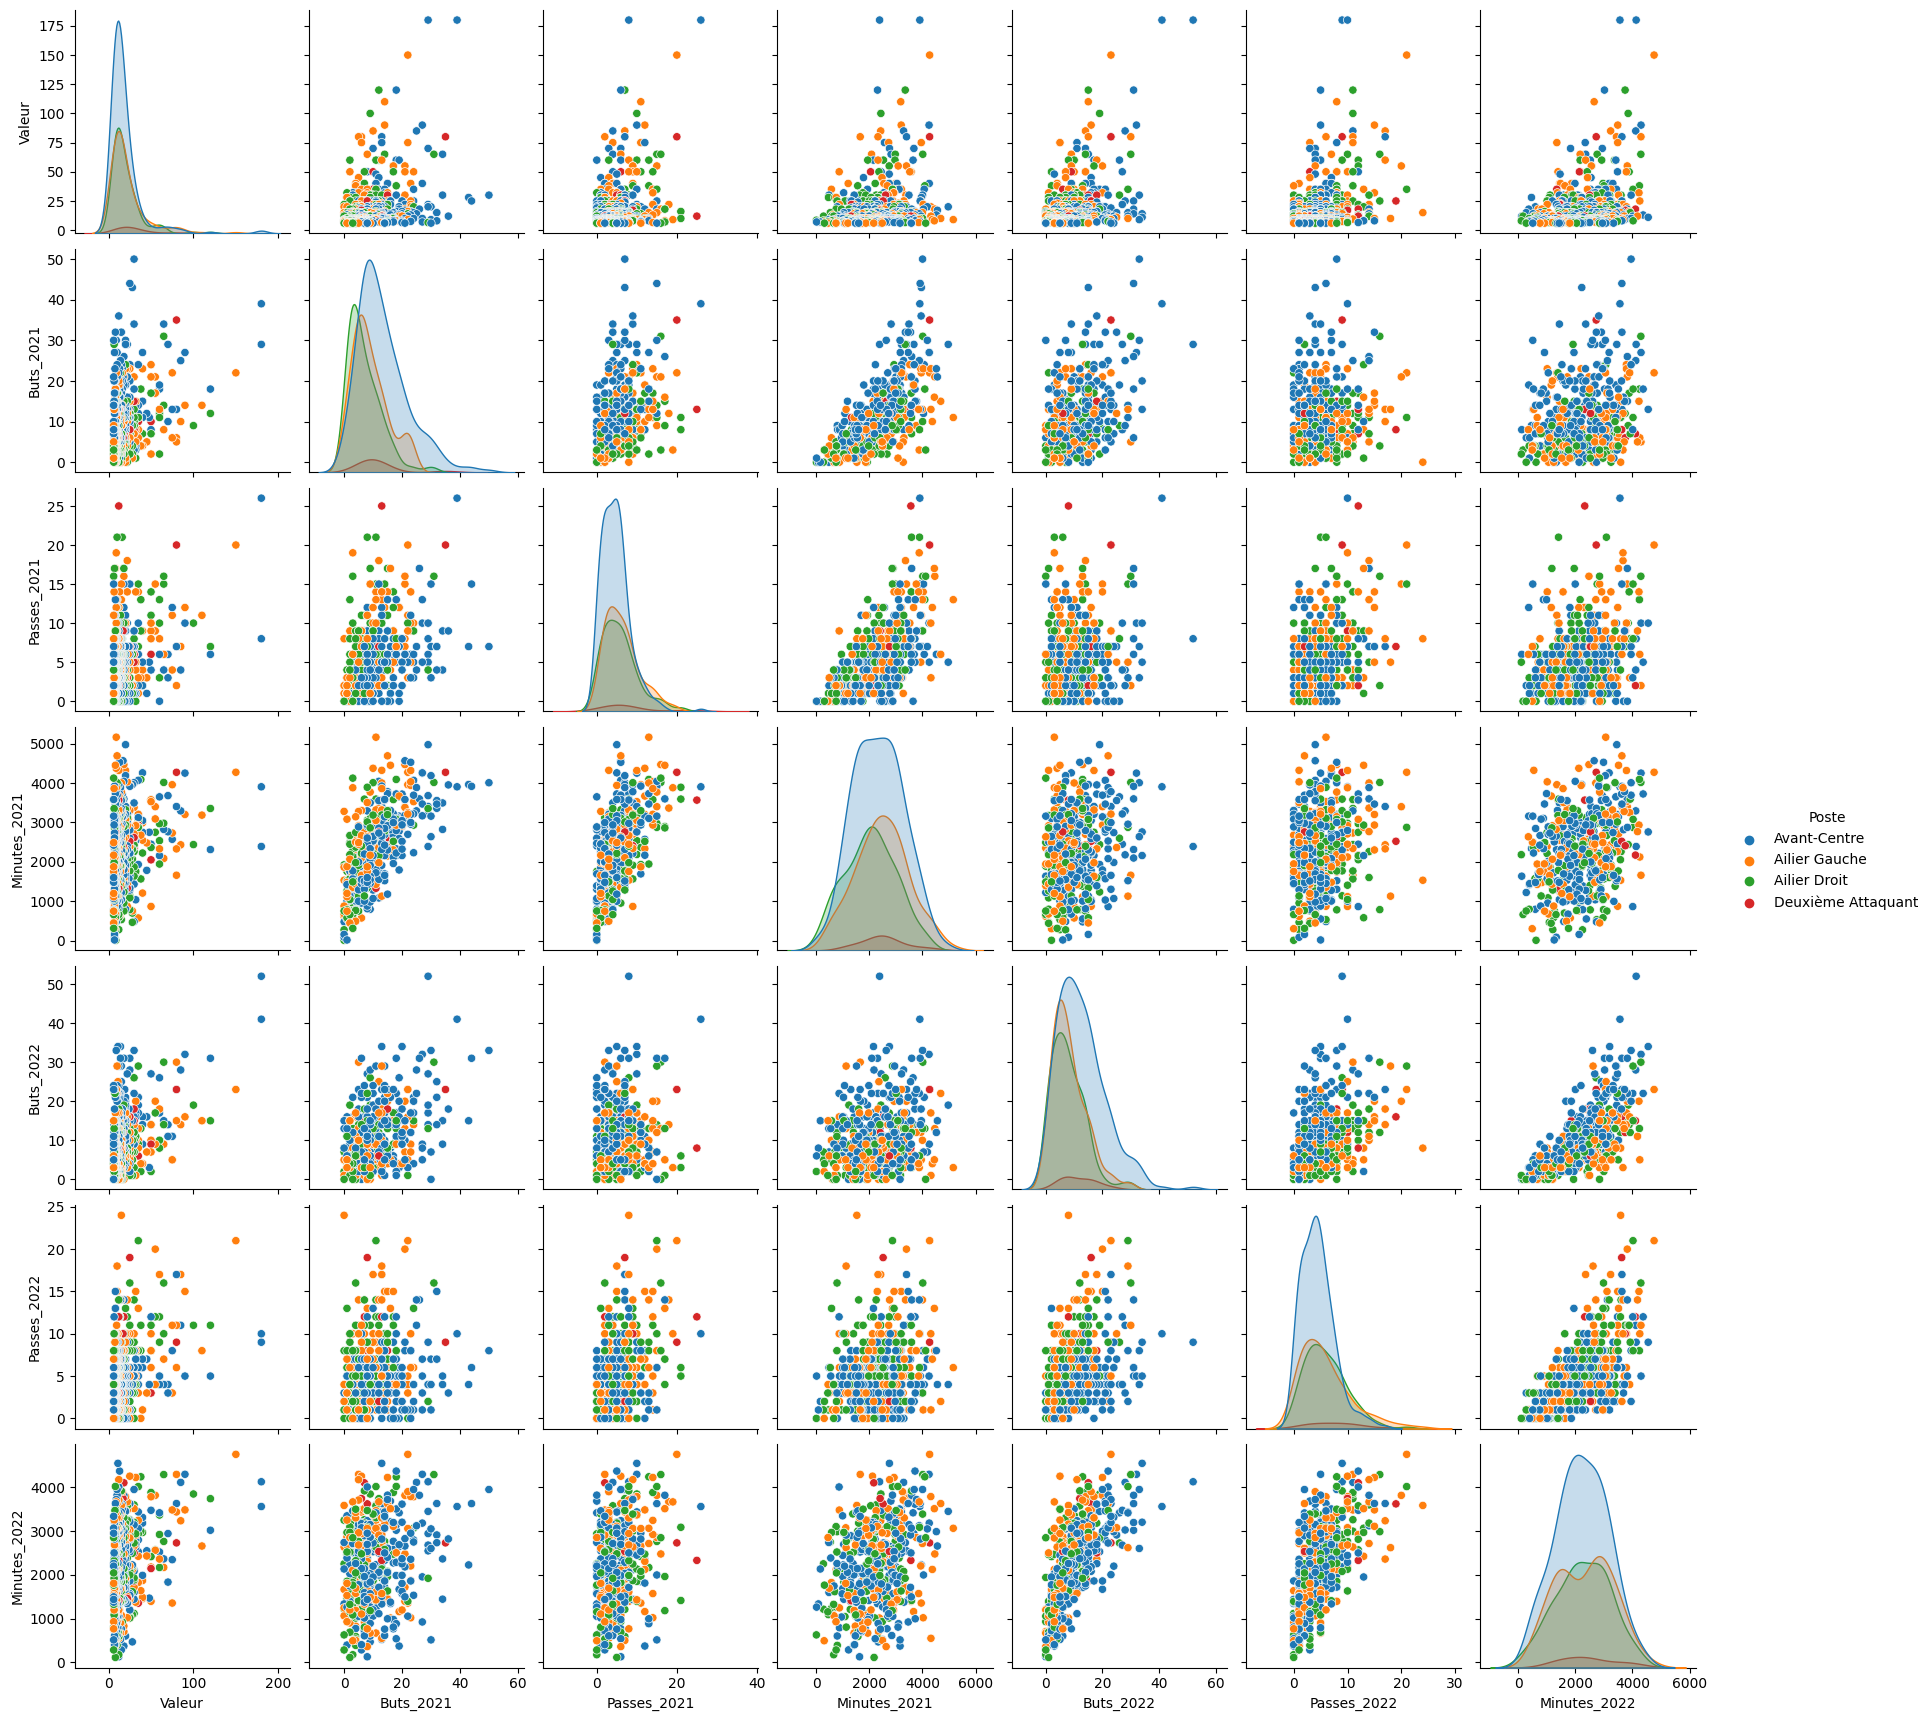

In [7]:
sns.pairplot(df[['Valeur', 'Buts_2021', 'Passes_2021', 'Minutes_2021', 'Buts_2022', 'Passes_2022', 'Minutes_2022', 'Poste']], hue='Poste')

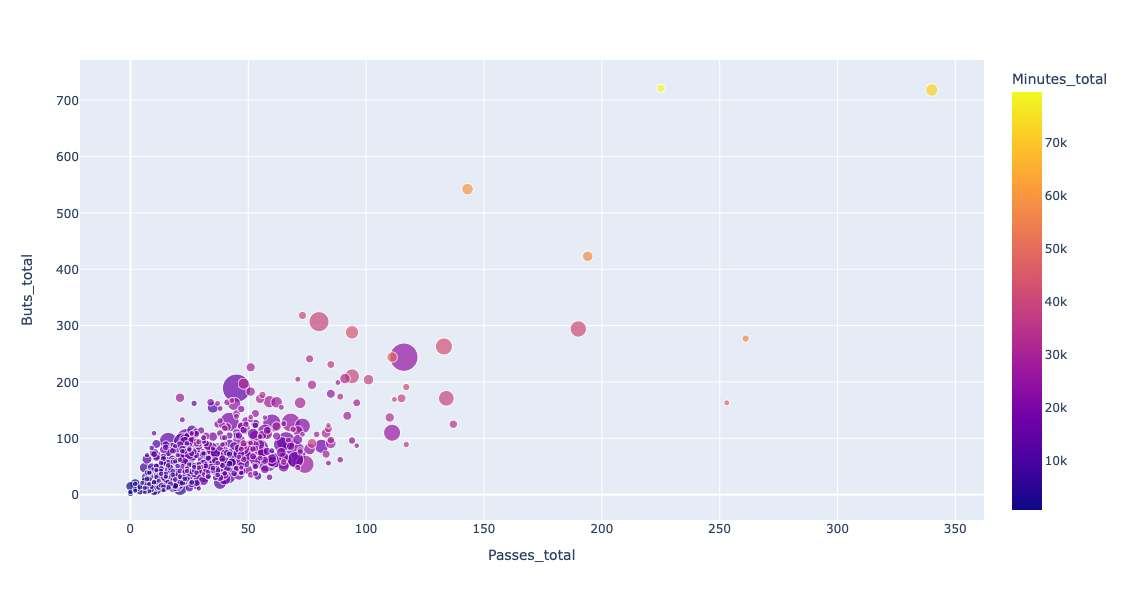

In [8]:
fig = px.scatter(df, x='Passes_total', y='Buts_total', color='Minutes_total', size='Valeur', hover_data=['Rang', 'Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

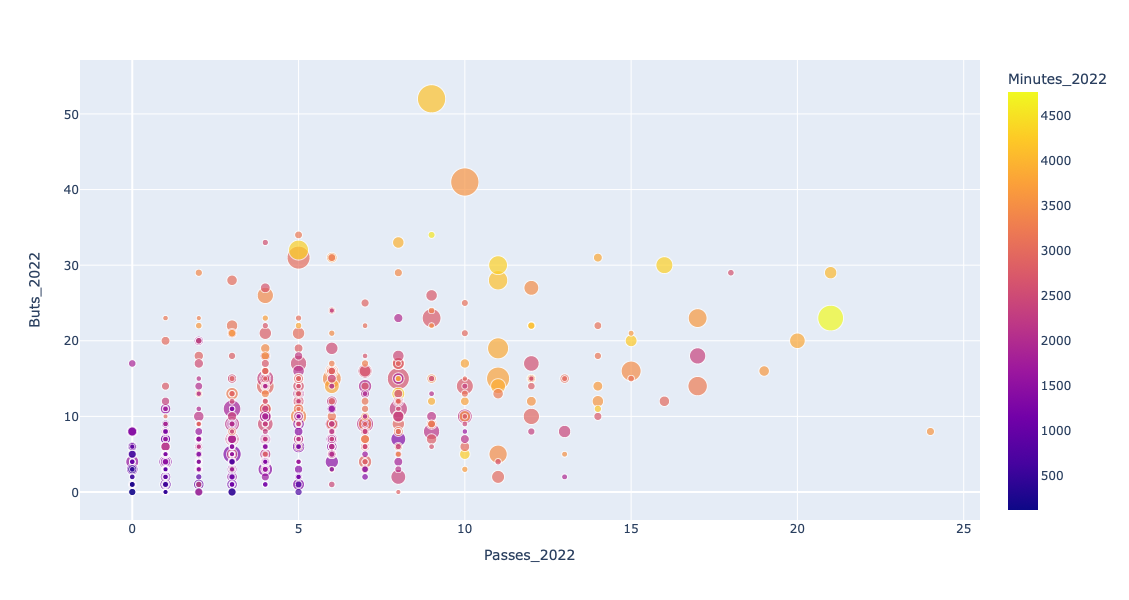

In [9]:
fig = px.scatter(df, x='Passes_2022', y='Buts_2022', color='Minutes_2022', size='Valeur', hover_data=['Rang', 'Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

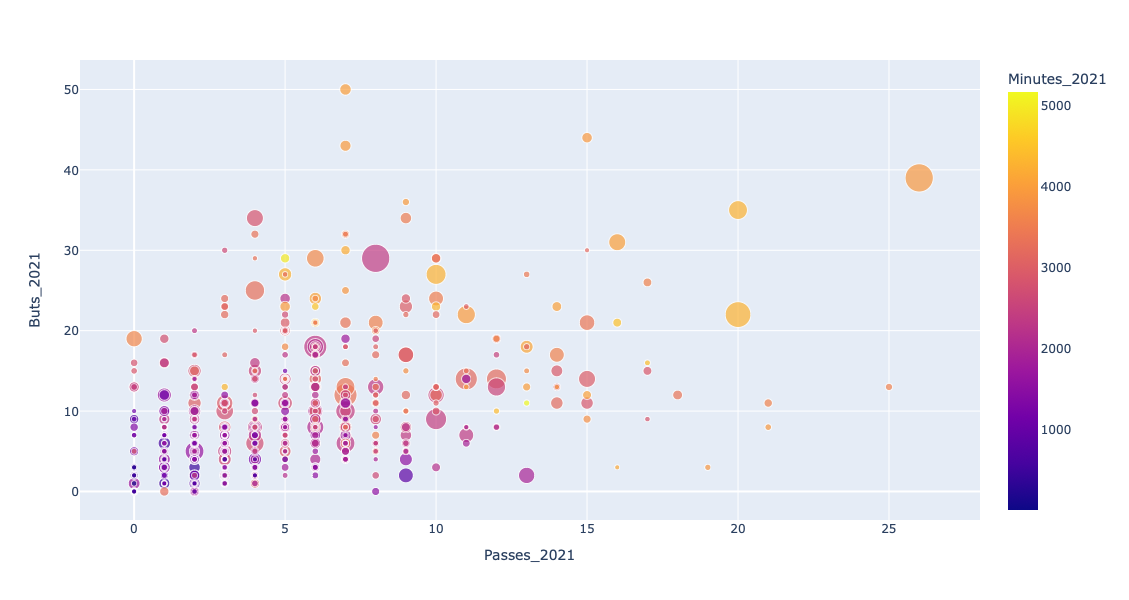

In [10]:
fig = px.scatter(df, x='Passes_2021', y='Buts_2021', color='Minutes_2021', size='Valeur', hover_data=['Rang', 'Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

In [11]:
df2 = df.copy()

In [12]:
df2.head()

Rang           Joueur          Poste  Age  Valeur  Buts_2021  Passes_2021  \
0     1   Erling Haaland   Avant-Centre   23   180.0         29            8   
1     2    Kylian Mbappé   Avant-Centre   24   180.0         39           26   
2     3  Vinicius Junior  Ailier Gauche   23   150.0         22           20   
3     4      Bukayo Saka   Ailier Droit   21   120.0         12            7   
4     5   Victor Osimhen   Avant-Centre   24   120.0         18            6   

   Minutes_2021  Buts_2022  Passes_2022  Minutes_2022  Buts_total  \
0          2388         52            9          4131         189   
1          3903         41           10          3564         244   
2          4272         23           21          4759          73   
3          3353         15           11          3744          61   
4          2310         31            5          3021          97   

   Passes_total  Minutes_total  
0            45          16189  
1           116          24452  
2            69          18064  
3            58          17186  
4            24          13467

In [13]:
# création de colonnes buts/min et passes/min

for year in [2021, 2022, 'total']:
    df2[f'buts_min_{str(year)}'] = df2[f'Buts_{str(year)}']/df2[f'Minutes_{str(year)}']
    df2[f'passes_min_{str(year)}'] = df2[f'Passes_{str(year)}']/df2[f'Minutes_{str(year)}']

In [14]:
df2.head()

Rang           Joueur          Poste  Age  Valeur  Buts_2021  Passes_2021  \
0     1   Erling Haaland   Avant-Centre   23   180.0         29            8   
1     2    Kylian Mbappé   Avant-Centre   24   180.0         39           26   
2     3  Vinicius Junior  Ailier Gauche   23   150.0         22           20   
3     4      Bukayo Saka   Ailier Droit   21   120.0         12            7   
4     5   Victor Osimhen   Avant-Centre   24   120.0         18            6   

   Minutes_2021  Buts_2022  Passes_2022  Minutes_2022  Buts_total  \
0          2388         52            9          4131         189   
1          3903         41           10          3564         244   
2          4272         23           21          4759          73   
3          3353         15           11          3744          61   
4          2310         31            5          3021          97   

   Passes_total  Minutes_total  buts_min_2021  passes_min_2021  buts_min_2022  \
0            45          16189       0.012144         0.003350       0.012588   
1           116          24452       0.009992         0.006662       0.011504   
2            69          18064       0.005150         0.004682       0.004833   
3            58          17186       0.003579         0.002088       0.004006   
4            24          13467       0.007792         0.002597       0.010262   

   passes_min_2022  buts_min_total  passes_min_total  
0         0.002179        0.011675          0.002780  
1         0.002806        0.009979          0.004744  
2         0.004413        0.004041          0.003820  
3         0.002938        0.003549          0.003375  
4         0.001655        0.007203          0.001782

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rang              500 non-null    int64  
 1   Joueur            500 non-null    object 
 2   Poste             500 non-null    object 
 3   Age               500 non-null    int64  
 4   Valeur            500 non-null    float64
 5   Buts_2021         500 non-null    int64  
 6   Passes_2021       500 non-null    int64  
 7   Minutes_2021      500 non-null    int64  
 8   Buts_2022         500 non-null    int64  
 9   Passes_2022       500 non-null    int64  
 10  Minutes_2022      500 non-null    int64  
 11  Buts_total        500 non-null    int64  
 12  Passes_total      500 non-null    int64  
 13  Minutes_total     500 non-null    int64  
 14  buts_min_2021     500 non-null    float64
 15  passes_min_2021   500 non-null    float64
 16  buts_min_2022     500 non-null    float64
 1

In [16]:
df2.describe()

Rang         Age     Valeur   Buts_2021  Passes_2021  \
count  500.000000  500.000000  500.00000  500.000000   500.000000   
mean   250.500000   24.984000   20.11700   10.532000     5.440000   
std    144.481833    3.561617   21.15007    7.877378     4.209732   
min      1.000000   17.000000    6.00000    0.000000     0.000000   
25%    125.750000   22.000000    8.00000    5.000000     2.000000   
50%    250.500000   25.000000   13.00000    8.500000     5.000000   
75%    375.250000   27.000000   22.25000   14.000000     7.000000   
max    500.000000   38.000000  180.00000   50.000000    26.000000   

       Minutes_2021   Buts_2022  Passes_2022  Minutes_2022  Buts_total  \
count    500.000000  500.000000   500.000000    500.000000  500.000000   
mean    2301.720000   10.252000     5.264000   2266.760000   75.840000   
std      971.872519    7.549735     3.923914    944.463656   71.270986   
min        7.000000    0.000000     0.000000    109.000000    2.000000   
25%     1578.000000    5.000000     2.000000   1565.500000   35.000000   
50%     2309.500000    9.000000     5.000000   2254.500000   61.000000   
75%     2976.250000   14.000000     7.000000   2962.250000   93.250000   
max     5162.000000   52.000000    24.000000   4759.000000  721.000000   

       Passes_total  Minutes_total  buts_min_2021  passes_min_2021  \
count    500.000000     500.000000     500.000000       500.000000   
mean      38.464000   16393.992000       0.004551         0.002303   
std       34.308408   10128.291757       0.003724         0.001477   
min        0.000000     632.000000       0.000000         0.000000   
25%       17.750000    9304.250000       0.002706         0.001262   
50%       30.000000   14748.000000       0.004095         0.002112   
75%       49.250000   21212.000000       0.005831         0.003124   
max      340.000000   79515.000000       0.066667         0.010393   

       buts_min_2022  passes_min_2022  buts_min_total  passes_min_total  
count     500.000000       500.000000      500.000000        500.000000  
mean        0.004338         0.002289        0.004496          0.002250  
std         0.002376         0.001450        0.001848          0.000880  
min         0.000000         0.000000        0.000844          0.000000  
25%         0.002654         0.001203        0.003172          0.001642  
50%         0.004077         0.002126        0.004328          0.002170  
75%         0.005808         0.003159        0.005577          0.002732  
max         0.012673         0.010638        0.015608          0.007652

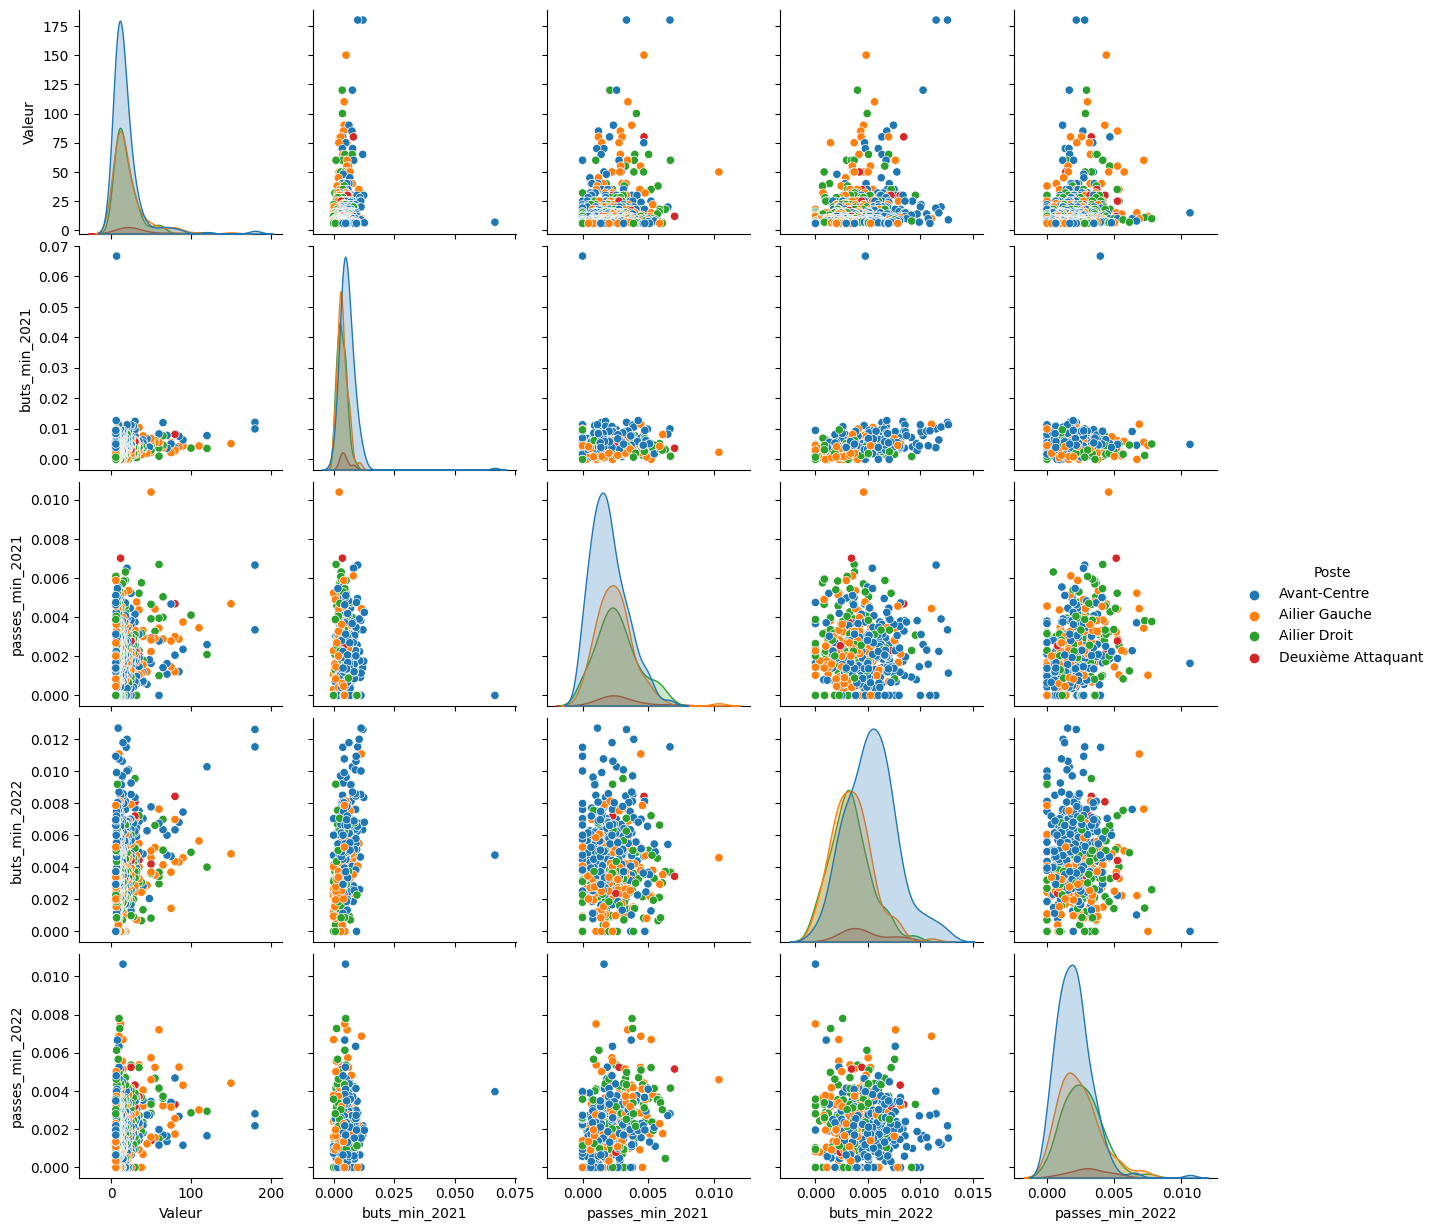

In [17]:
sns.pairplot(df2[['Valeur', 'buts_min_2021', 'passes_min_2021', 'buts_min_2022', 'passes_min_2022', 'Poste']], hue='Poste')

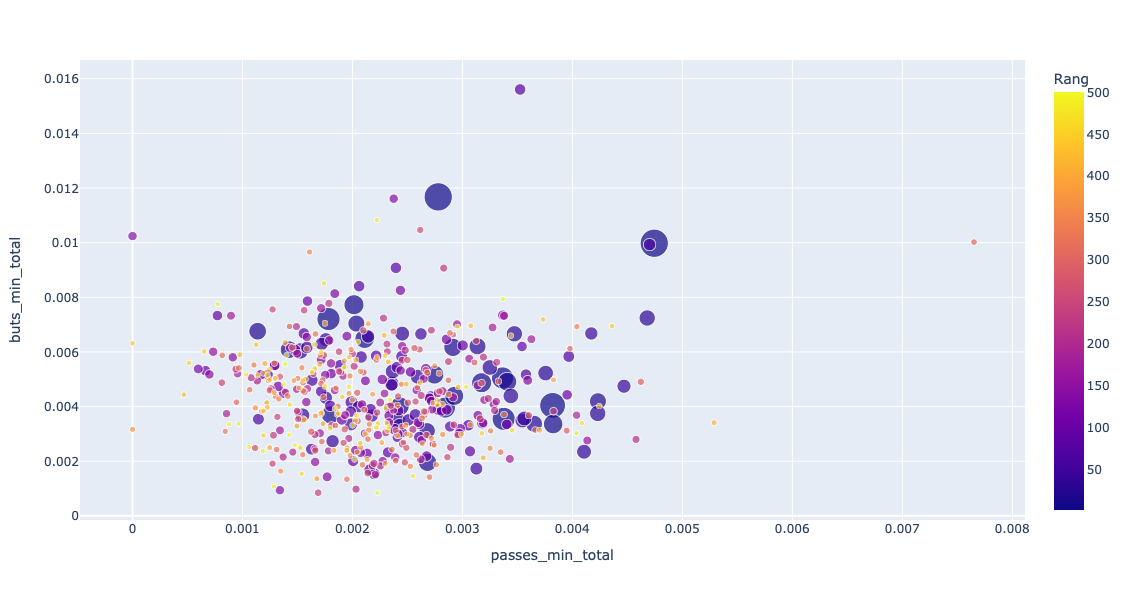

In [18]:
fig = px.scatter(df2, x='passes_min_total', y='buts_min_total', color='Rang', size='Valeur', hover_data=['Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

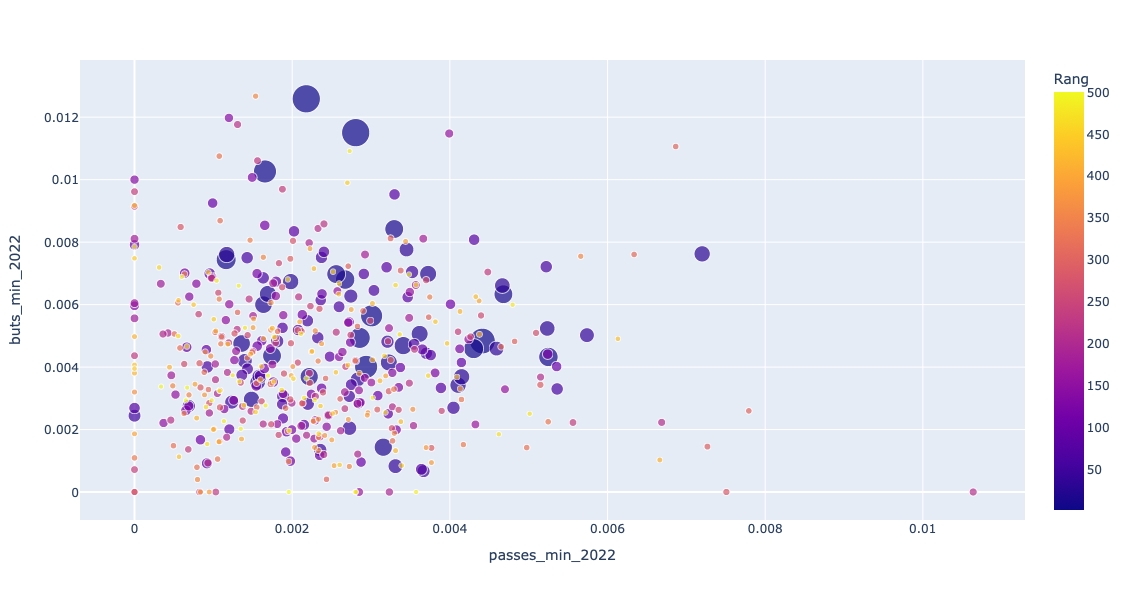

In [19]:
fig = px.scatter(df2, x='passes_min_2022', y='buts_min_2022', color='Rang', size='Valeur', hover_data=['Rang', 'Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

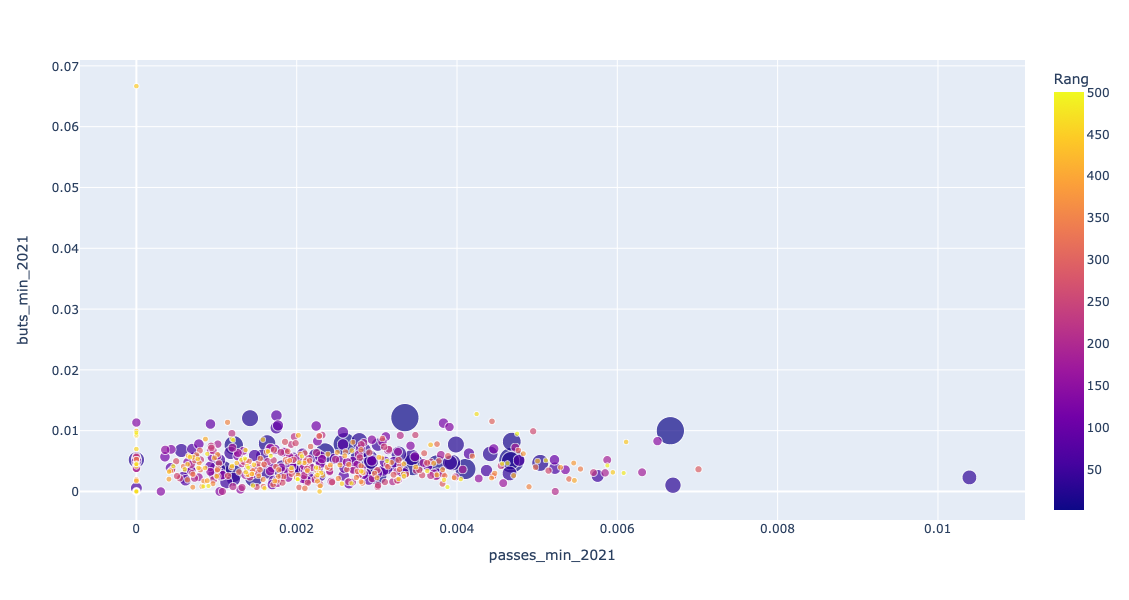

In [20]:
fig = px.scatter(df2, x='passes_min_2021', y='buts_min_2021', color='Rang', size='Valeur', hover_data=['Rang', 'Joueur', 'Age', 'Poste'], 
                  width=1200, height=600)
fig.show()

# DNN Model

Verbosity during training : 
- 0 = silent
- 1 = progress bar
- 2 = one line per epoch

In [21]:
fit_verbosity = 2

## Step 1 - Preparing the data
### 1.1 - Prepare data for analysis

In [22]:
data = df.drop(columns=['Rang', 'Joueur', 'Poste'])

In [23]:
display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ', data.isna().sum().sum(), '  Shape is : ', data.shape)

Missing Data :  0   Shape is :  (500, 11)


### 1.2 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the market value

In [24]:
# ---- Split => train, test
#
data       = data.sample(frac=1., axis=0)     # Shuffle
data_train = data.sample(frac=0.8, axis=0)    # get 80 %
data_test  = data.drop(data_train.index)      # test = all - train

# ---- Split => x,y (y is quality)
#
x_train = data_train.drop('Valeur', axis=1)
y_train = data_train['Valeur']
x_test  = data_test.drop('Valeur', axis=1)
y_test  = data_test['Valeur']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (500, 11)
x_train :  (400, 10) y_train :  (400,)
x_test  :  (100, 10) y_test  :  (100,)


### 1.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [25]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)

## Step 2 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [26]:
def get_model_v1(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 3 - Train the model
### 3.1 - Get it

In [27]:
model=get_model_v1( (10,) )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                704       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 - Add callback

In [28]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True) 
# sauvegarde le modèle slmt si meilleur que l'époque d'avant

### 3.3 - Train it

In [29]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 130,
                    batch_size      = 20,
                    verbose         = fit_verbosity,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/130
20/20 - 0s - loss: 815.7832 - mae: 19.2655 - mse: 815.7832 - val_loss: 743.1696 - val_mae: 16.9965 - val_mse: 743.1696 - 258ms/epoch - 13ms/step
Epoch 2/130
20/20 - 0s - loss: 722.4152 - mae: 16.8831 - mse: 722.4152 - val_loss: 644.2495 - val_mae: 14.4966 - val_mse: 644.2495 - 19ms/epoch - 963us/step
Epoch 3/130
20/20 - 0s - loss: 626.3166 - mae: 14.5394 - mse: 626.3166 - val_loss: 543.2174 - val_mae: 12.3434 - val_mse: 543.2174 - 20ms/epoch - 990us/step
Epoch 4/130
20/20 - 0s - loss: 538.3391 - mae: 12.9107 - mse: 538.3391 - val_loss: 460.5939 - val_mae: 11.1968 - val_mse: 460.5939 - 20ms/epoch - 1ms/step
Epoch 5/130
20/20 - 0s - loss: 471.3308 - mae: 12.2412 - mse: 471.3308 - val_loss: 389.9448 - val_mae: 10.6795 - val_mse: 389.9448 - 21ms/epoch - 1ms/step
Epoch 6/130
20/20 - 0s - loss: 429.7330 - mae: 12.2792 - mse: 429.7330 - val_loss: 354.9977 - val_mae: 10.7624 - val_mse: 354.9977 - 20ms/epoch - 984us/step
Epoch 7/130
20/20 - 0s - loss: 405.2173 - mae: 12.2481 - mse: 

/opt/miniconda3/envs/reg-prix-football/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



20/20 - 0s - loss: 360.0496 - mae: 12.0655 - mse: 360.0496 - val_loss: 301.6322 - val_mae: 11.2858 - val_mse: 301.6322 - 18ms/epoch - 884us/step
Epoch 12/130
20/20 - 0s - loss: 353.5213 - mae: 12.0359 - mse: 353.5213 - val_loss: 302.0411 - val_mae: 11.2176 - val_mse: 302.0411 - 14ms/epoch - 717us/step
Epoch 13/130
20/20 - 0s - loss: 348.8745 - mae: 11.9528 - mse: 348.8745 - val_loss: 302.5214 - val_mae: 11.2263 - val_mse: 302.5214 - 15ms/epoch - 728us/step
Epoch 14/130
20/20 - 0s - loss: 343.8184 - mae: 11.7485 - mse: 343.8184 - val_loss: 299.7957 - val_mae: 11.4153 - val_mse: 299.7957 - 18ms/epoch - 879us/step
Epoch 15/130
20/20 - 0s - loss: 338.4093 - mae: 11.9001 - mse: 338.4093 - val_loss: 300.6591 - val_mae: 11.3212 - val_mse: 300.6591 - 14ms/epoch - 678us/step
Epoch 16/130
20/20 - 0s - loss: 335.3157 - mae: 11.8853 - mse: 335.3157 - val_loss: 301.5768 - val_mae: 11.2624 - val_mse: 301.5768 - 14ms/epoch - 724us/step
Epoch 17/130
20/20 - 0s - loss: 330.1622 - mae: 11.8370 - mse: 33

## Step 4 - Evaluate
### 4.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  

In [30]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 308.0541
x_test / mae       : 11.7117
x_test / mse       : 308.0541


### 4.2 - Training history
What was the best result during our training ?

In [31]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 10.6795


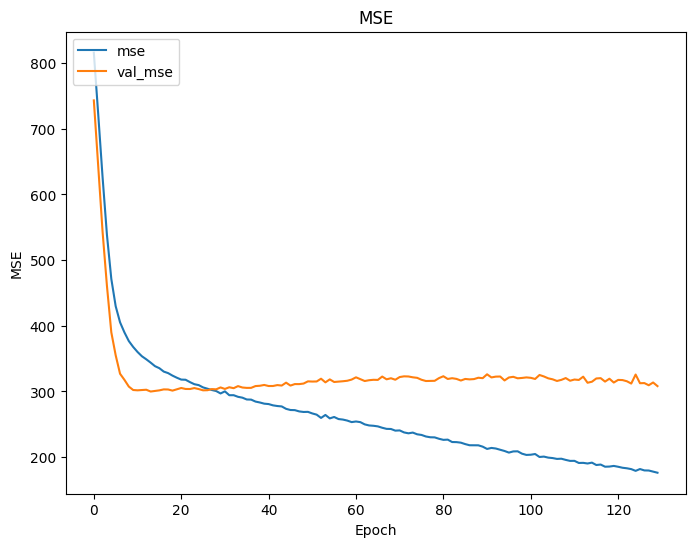

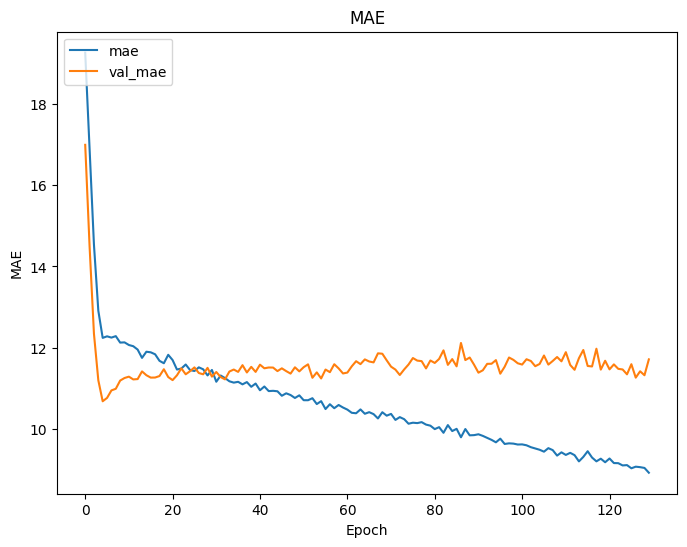

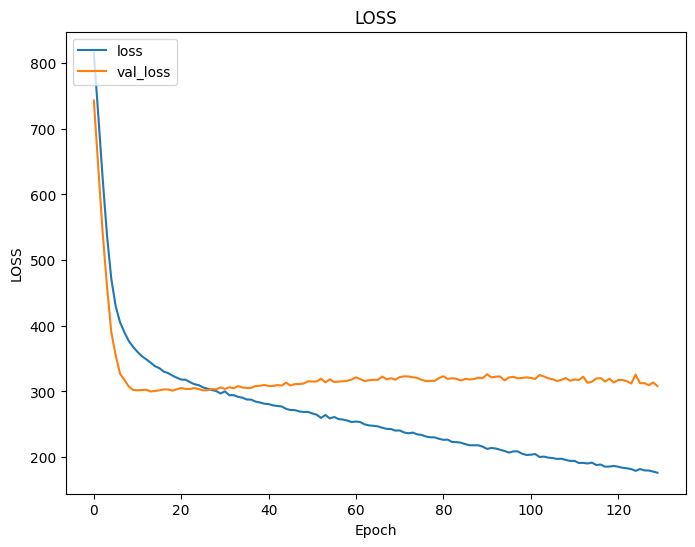

In [32]:
plot_history( history, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='history')

## Step 5 - Restore a model :
### 5.1 - Reload model

In [33]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                704       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4929 (19.25 KB)
Trainable params: 4929 (19.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Loaded.


### 5.2 - Evaluate it :

In [34]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 299.7957
x_test / mae       : 11.4153
x_test / mse       : 299.7957


### 5.3 - Make a prediction

In [35]:
# ---- Pick n entries from our test set
n = 50
ii = np.random.randint(1,len(x_test),n)
x_sample = x_test[ii]
y_sample = y_test[ii]

In [36]:
# ---- Make a predictions
y_pred = loaded_model.predict( x_sample, verbose=2 )

2/2 - 0s - 39ms/epoch - 20ms/step


In [37]:
# ---- Show it
print('Joueur    Prediction   Real   Delta')
for i in range(n):
    pred   = y_pred[i][0]
    real   = y_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Joueur    Prediction   Real   Delta
000        13.16       8.0      -5.16 
001        10.86       70.0      +59.14 
002        23.47       12.0      -11.47 
003        10.05       10.0      -0.05 
004        13.75       6.0      -7.75 
005        9.72       8.0      -1.72 
006        10.05       10.0      -0.05 
007        12.97       15.0      +2.03 
008        12.74       15.0      +2.26 
009        20.27       30.0      +9.73 
010        17.62       6.0      -11.62 
011        18.26       18.0      -0.26 
012        8.64       48.0      +39.36 
013        23.65       30.0      +6.35 
014        15.48       19.0      +3.52 
015        20.27       30.0      +9.73 
016        9.97       8.0      -1.97 
017        14.77       14.0      -0.77 
018        19.74       35.0      +15.26 
019        33.98       35.0      +1.02 
020        11.60       11.0      -0.60 
021        31.77       9.0      -22.77 
022        9.37       12.0      +2.63 
023        20.38       9.0      -11.38 
024     

# DNN Model avec df2

## Step 1 - Preparing the data
### 1.1 - Prepare data for analysis

In [38]:
df2.head()

Rang           Joueur          Poste  Age  Valeur  Buts_2021  Passes_2021  \
0     1   Erling Haaland   Avant-Centre   23   180.0         29            8   
1     2    Kylian Mbappé   Avant-Centre   24   180.0         39           26   
2     3  Vinicius Junior  Ailier Gauche   23   150.0         22           20   
3     4      Bukayo Saka   Ailier Droit   21   120.0         12            7   
4     5   Victor Osimhen   Avant-Centre   24   120.0         18            6   

   Minutes_2021  Buts_2022  Passes_2022  Minutes_2022  Buts_total  \
0          2388         52            9          4131         189   
1          3903         41           10          3564         244   
2          4272         23           21          4759          73   
3          3353         15           11          3744          61   
4          2310         31            5          3021          97   

   Passes_total  Minutes_total  buts_min_2021  passes_min_2021  buts_min_2022  \
0            45          16189       0.012144         0.003350       0.012588   
1           116          24452       0.009992         0.006662       0.011504   
2            69          18064       0.005150         0.004682       0.004833   
3            58          17186       0.003579         0.002088       0.004006   
4            24          13467       0.007792         0.002597       0.010262   

   passes_min_2022  buts_min_total  passes_min_total  
0         0.002179        0.011675          0.002780  
1         0.002806        0.009979          0.004744  
2         0.004413        0.004041          0.003820  
3         0.002938        0.003549          0.003375  
4         0.001655        0.007203          0.001782

In [39]:
data2 = df2.drop(columns=['Rang', 'Joueur', 'Poste', 'Minutes_2021', 'Minutes_2022', 'Minutes_total', 
                          'Buts_2021', 'Buts_2022', 'Buts_total',
                          'Passes_2021', 'Passes_2022', 'Passes_total'])

In [40]:
display(data2.head(5).style.format("{0:.2f}"))
print('Missing Data : ', data2.isna().sum().sum(), '  Shape is : ', data2.shape)

Missing Data :  0   Shape is :  (500, 8)


### 1.2 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the market value

In [41]:
# ---- Split => train, test
#
data2       = data2.sample(frac=1., axis=0)     # Shuffle
data2_train = data2.sample(frac=0.8, axis=0)    # get 80 %
data2_test  = data2.drop(data2_train.index)     # test = all - train

# ---- Split => x,y (y is quality)
#
x2_train = data2_train.drop('Valeur', axis=1)
y2_train = data2_train['Valeur']
x2_test  = data2_test.drop('Valeur', axis=1)
y2_test  = data2_test['Valeur']

print('Original data shape was : ',data2.shape)
print('x_train : ',x2_train.shape, 'y_train : ',y2_train.shape)
print('x_test  : ',x2_test.shape,  'y_test  : ',y2_test.shape)

Original data shape was :  (500, 8)
x_train :  (400, 7) y_train :  (400,)
x_test  :  (100, 7) y_test  :  (100,)


### 1.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [42]:
display(x2_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean2 = x2_train.mean()
std2  = x2_train.std()
x2_train = (x2_train - mean2) / std2
x2_test  = (x2_test  - mean2) / std2

display(x2_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x2_train, y2_train = np.array(x2_train), np.array(y2_train)
x2_test,  y2_test  = np.array(x2_test),  np.array(y2_test)

## Step 2 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [43]:
def get_model_v2(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 3 - Train the model
### 3.1 - Get it

In [44]:
model2=get_model_v2( (7,) )

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                512       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 - Add callback

In [45]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir2 = "./run/models/best_model2.h5"

savemodel_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir2, verbose=0, save_best_only=True) 
# sauvegarde le modèle slmt si meilleur que l'époque d'avant

### 3.3 - Train it

In [46]:
history2 = model2.fit(x2_train,
                    y2_train,
                    epochs          = 130,
                    batch_size      = 20,
                    verbose         = fit_verbosity,
                    validation_data = (x2_test, y2_test),
                    callbacks       = [savemodel_callback2])

Epoch 1/130
20/20 - 0s - loss: 815.4317 - mae: 18.5966 - mse: 815.4317 - val_loss: 666.4678 - val_mae: 18.1986 - val_mse: 666.4678 - 203ms/epoch - 10ms/step
Epoch 2/130
20/20 - 0s - loss: 724.1420 - mae: 16.3977 - mse: 724.1420 - val_loss: 586.0562 - val_mae: 15.9902 - val_mse: 586.0562 - 19ms/epoch - 957us/step
Epoch 3/130
20/20 - 0s - loss: 634.6793 - mae: 14.0320 - mse: 634.6794 - val_loss: 512.5182 - val_mae: 13.9401 - val_mse: 512.5182 - 21ms/epoch - 1ms/step
Epoch 4/130
20/20 - 0s - loss: 552.2352 - mae: 12.2870 - mse: 552.2352 - val_loss: 448.5520 - val_mae: 13.0850 - val_mse: 448.5520 - 21ms/epoch - 1ms/step
Epoch 5/130
20/20 - 0s - loss: 494.6282 - mae: 11.5585 - mse: 494.6282 - val_loss: 415.5751 - val_mae: 12.9299 - val_mse: 415.5751 - 20ms/epoch - 989us/step
Epoch 6/130
20/20 - 0s - loss: 466.1359 - mae: 11.8959 - mse: 466.1359 - val_loss: 405.5239 - val_mae: 13.1235 - val_mse: 405.5239 - 22ms/epoch - 1ms/step
Epoch 7/130
20/20 - 0s - loss: 449.9836 - mae: 12.0571 - mse: 44

/opt/miniconda3/envs/reg-prix-football/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



20/20 - 0s - loss: 425.0580 - mae: 12.1492 - mse: 425.0580 - val_loss: 416.5311 - val_mae: 13.7144 - val_mse: 416.5311 - 15ms/epoch - 743us/step
Epoch 12/130
20/20 - 0s - loss: 420.4063 - mae: 12.1946 - mse: 420.4063 - val_loss: 420.7585 - val_mae: 13.7697 - val_mse: 420.7585 - 14ms/epoch - 710us/step
Epoch 13/130
20/20 - 0s - loss: 418.8820 - mae: 12.2547 - mse: 418.8820 - val_loss: 425.1190 - val_mae: 13.8167 - val_mse: 425.1190 - 14ms/epoch - 696us/step
Epoch 14/130
20/20 - 0s - loss: 414.4432 - mae: 12.1947 - mse: 414.4432 - val_loss: 428.2206 - val_mae: 13.8380 - val_mse: 428.2206 - 14ms/epoch - 721us/step
Epoch 15/130
20/20 - 0s - loss: 411.7411 - mae: 12.0693 - mse: 411.7411 - val_loss: 434.5300 - val_mae: 13.9390 - val_mse: 434.5300 - 14ms/epoch - 695us/step
Epoch 16/130
20/20 - 0s - loss: 409.6717 - mae: 12.2416 - mse: 409.6717 - val_loss: 436.1663 - val_mae: 13.9087 - val_mse: 436.1663 - 14ms/epoch - 676us/step
Epoch 17/130
20/20 - 0s - loss: 408.8662 - mae: 12.0797 - mse: 40

## Step 4 - Evaluate
### 4.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  

In [47]:
score2 = model2.evaluate(x2_test, y2_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score2[0]))
print('x_test / mae       : {:5.4f}'.format(score2[1]))
print('x_test / mse       : {:5.4f}'.format(score2[2]))

x_test / loss      : 585.4214
x_test / mae       : 14.1838
x_test / mse       : 585.4214


### 4.2 - Training history
What was the best result during our training ?

In [48]:
print("min( val_mae ) : {:.4f}".format( min(history2.history["val_mae"]) ) )

min( val_mae ) : 12.9299


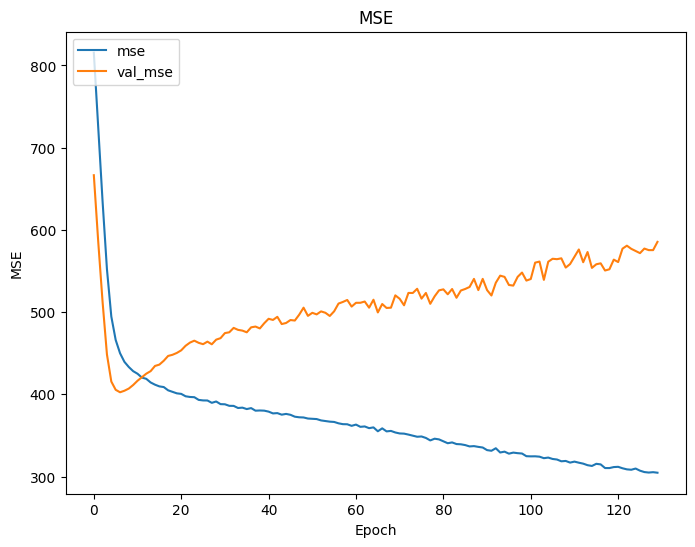

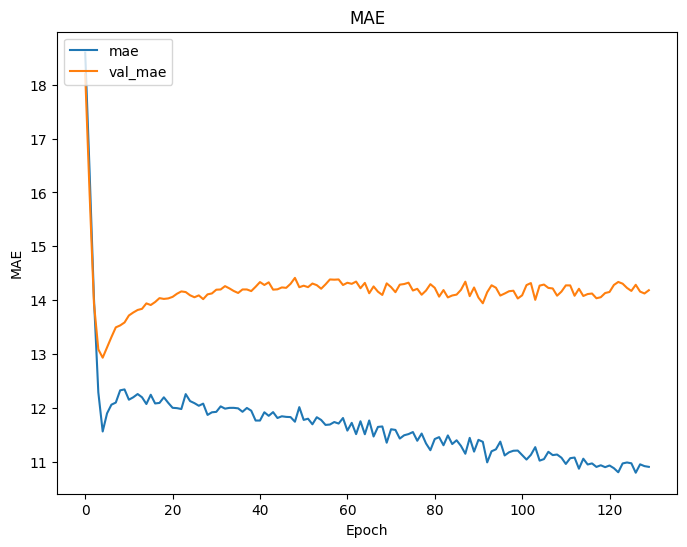

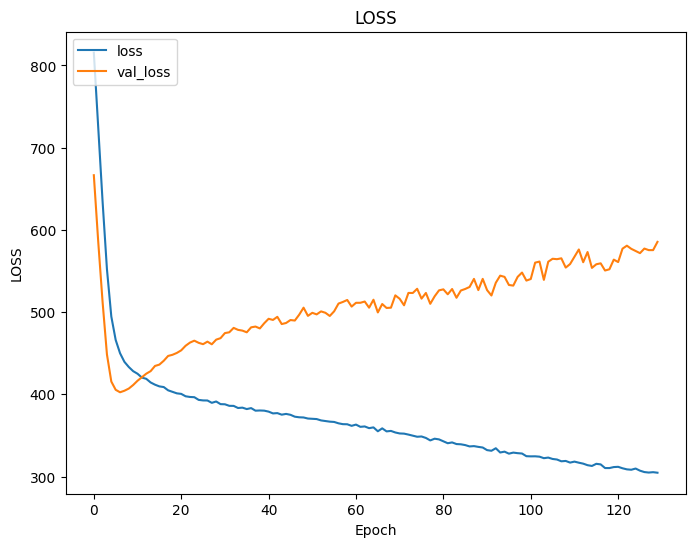

In [49]:
plot_history( history2, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='history2')

## Step 5 - Restore a model :
### 5.1 - Reload model

In [50]:
loaded_model2 = tf.keras.models.load_model('./run/models/best_model2.h5')
loaded_model2.summary()
print("Loaded.")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                512       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4737 (18.50 KB)
Trainable params: 4737 (18.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Loaded.


### 5.2 - Evaluate it :

In [51]:
score2 = loaded_model2.evaluate(x2_test, y2_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score2[0]))
print('x_test / mae       : {:5.4f}'.format(score2[1]))
print('x_test / mse       : {:5.4f}'.format(score2[2]))

x_test / loss      : 402.5226
x_test / mae       : 13.3128
x_test / mse       : 402.5226


### 5.3 - Make a prediction

In [52]:
# ---- Pick n entries from our test set
n = 50
ii = np.random.randint(1,len(x2_test),n)
x2_sample = x2_test[ii]
y2_sample = y2_test[ii]

In [53]:
# ---- Make a predictions
y2_pred = loaded_model2.predict( x2_sample, verbose=2 )

2/2 - 0s - 17ms/epoch - 9ms/step


In [54]:
# ---- Show it
print('Joueur    Prediction   Real   Delta')
for i in range(n):
    pred   = y2_pred[i][0]
    real   = y2_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Joueur    Prediction   Real   Delta
000        17.38       10.0      -7.38 
001        10.37       12.0      +1.63 
002        12.83       6.0      -6.83 
003        10.68       16.0      +5.32 
004        14.43       8.0      -6.43 
005        10.40       18.0      +7.60 
006        18.15       80.0      +61.85 
007        13.18       25.0      +11.82 
008        21.16       110.0      +88.84 
009        15.28       32.0      +16.72 
010        13.41       50.0      +36.59 
011        16.19       8.0      -8.19 
012        15.75       7.5      -8.25 
013        14.65       25.0      +10.35 
014        11.25       20.0      +8.75 
015        15.13       9.0      -6.13 
016        16.79       60.0      +43.21 
017        13.85       15.0      +1.15 
018        16.90       35.0      +18.10 
019        14.03       25.0      +10.97 
020        35.90       6.0      -29.90 
021        15.46       8.0      -7.46 
022        13.43       6.0      -7.43 
023        12.58       14.0      +1.42 
0

# DNN Model avec df2 - v2

## Step 1 - Preparing the data
### 1.1 - Prepare data for analysis

In [55]:
df2.head()

Rang           Joueur          Poste  Age  Valeur  Buts_2021  Passes_2021  \
0     1   Erling Haaland   Avant-Centre   23   180.0         29            8   
1     2    Kylian Mbappé   Avant-Centre   24   180.0         39           26   
2     3  Vinicius Junior  Ailier Gauche   23   150.0         22           20   
3     4      Bukayo Saka   Ailier Droit   21   120.0         12            7   
4     5   Victor Osimhen   Avant-Centre   24   120.0         18            6   

   Minutes_2021  Buts_2022  Passes_2022  Minutes_2022  Buts_total  \
0          2388         52            9          4131         189   
1          3903         41           10          3564         244   
2          4272         23           21          4759          73   
3          3353         15           11          3744          61   
4          2310         31            5          3021          97   

   Passes_total  Minutes_total  buts_min_2021  passes_min_2021  buts_min_2022  \
0            45          16189       0.012144         0.003350       0.012588   
1           116          24452       0.009992         0.006662       0.011504   
2            69          18064       0.005150         0.004682       0.004833   
3            58          17186       0.003579         0.002088       0.004006   
4            24          13467       0.007792         0.002597       0.010262   

   passes_min_2022  buts_min_total  passes_min_total  
0         0.002179        0.011675          0.002780  
1         0.002806        0.009979          0.004744  
2         0.004413        0.004041          0.003820  
3         0.002938        0.003549          0.003375  
4         0.001655        0.007203          0.001782

In [56]:
# data2 = df2.drop(columns=['Rang', 'Joueur', 'Poste', 'Minutes_2021', 'Minutes_2022', 'Minutes_total', 
#                           'Buts_2021', 'Buts_2022', 'Buts_total',
#                           'Passes_2021', 'Passes_2022', 'Passes_total'])

# Try without total data
data3 = df2.drop(columns=['Rang', 'Joueur', 'Poste', 'Minutes_2021', 'Minutes_2022', 'Minutes_total', 
                          'Buts_2021', 'Buts_2022', 'Buts_total',
                          'Passes_2021', 'Passes_2022', 'Passes_total', 
                          'buts_min_total', 'passes_min_total'])

In [57]:
display(data3.head(5).style.format("{0:.2f}"))
print('Missing Data : ', data3.isna().sum().sum(), '  Shape is : ', data3.shape)

Missing Data :  0   Shape is :  (500, 6)


### 1.2 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be the data of the analysis and y the market value

In [58]:
# ---- Split => train, test
#
data3       = data3.sample(frac=1., axis=0)     # Shuffle
data3_train = data3.sample(frac=0.8, axis=0)    # get 80 %
data3_test  = data3.drop(data3_train.index)     # test = all - train

# ---- Split => x,y (y is quality)
#
x3_train = data3_train.drop('Valeur', axis=1)
y3_train = data3_train['Valeur']
x3_test  = data3_test.drop('Valeur', axis=1)
y3_test  = data3_test['Valeur']

print('Original data shape was : ',data3.shape)
print('x_train : ',x3_train.shape, 'y_train : ',y3_train.shape)
print('x_test  : ',x3_test.shape,  'y_test  : ',y3_test.shape)

Original data shape was :  (500, 6)
x_train :  (400, 5) y_train :  (400,)
x_test  :  (100, 5) y_test  :  (100,)


### 1.3 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [59]:
display(x3_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean3 = x3_train.mean()
std3  = x3_train.std()
x3_train = (x3_train - mean3) / std3
x3_test  = (x3_test  - mean3) / std3

display(x3_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

# Convert ou DataFrame to numpy array
x3_train, y3_train = np.array(x3_train), np.array(y3_train)
x3_test,  y3_test  = np.array(x3_test),  np.array(y3_test)

## Step 2 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [60]:
def get_model_v3(shape):
  
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape, name="InputLayer"))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
  model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
  model.add(keras.layers.Dense(1, name='Output'))

  model.compile(optimizer = 'rmsprop',
                loss      = 'mse',
                metrics   = ['mae', 'mse'] )
  return model

## Step 3 - Train the model
### 3.1 - Get it

In [61]:
model3=get_model_v3( (5,) )

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                384       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 3.2 - Add callback

In [62]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir3 = "./run/models/best_model3.h5"

savemodel_callback3 = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir3, verbose=0, save_best_only=True) 
# sauvegarde le modèle slmt si meilleur que l'époque d'avant

### 3.3 - Train it

In [63]:
history3 = model3.fit(x3_train,
                    y3_train,
                    epochs          = 100,
                    batch_size      = 20,
                    verbose         = fit_verbosity,
                    validation_data = (x3_test, y3_test),
                    callbacks       = [savemodel_callback3])

Epoch 1/100
20/20 - 0s - loss: 779.9983 - mae: 18.7242 - mse: 779.9983 - val_loss: 833.8044 - val_mae: 18.1661 - val_mse: 833.8044 - 196ms/epoch - 10ms/step
Epoch 2/100
20/20 - 0s - loss: 698.0225 - mae: 16.4738 - mse: 698.0224 - val_loss: 758.3436 - val_mae: 15.9118 - val_mse: 758.3436 - 21ms/epoch - 1ms/step
Epoch 3/100
20/20 - 0s - loss: 614.9669 - mae: 13.9674 - mse: 614.9669 - val_loss: 710.8298 - val_mae: 14.1240 - val_mse: 710.8298 - 19ms/epoch - 971us/step
Epoch 4/100
20/20 - 0s - loss: 541.5840 - mae: 12.3791 - mse: 541.5840 - val_loss: 697.4622 - val_mae: 13.5307 - val_mse: 697.4622 - 19ms/epoch - 935us/step
Epoch 5/100
20/20 - 0s - loss: 488.1642 - mae: 11.8943 - mse: 488.1642 - val_loss: 722.6129 - val_mae: 13.7465 - val_mse: 722.6129 - 15ms/epoch - 736us/step
Epoch 6/100
20/20 - 0s - loss: 460.2660 - mae: 12.2694 - mse: 460.2660 - val_loss: 752.7861 - val_mae: 14.0724 - val_mse: 752.7861 - 14ms/epoch - 697us/step
Epoch 7/100
20/20 - 0s - loss: 448.1235 - mae: 12.5637 - mse

/opt/miniconda3/envs/reg-prix-football/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



20/20 - 0s - loss: 426.1630 - mae: 12.6259 - mse: 426.1630 - val_loss: 741.2470 - val_mae: 14.3598 - val_mse: 741.2470 - 14ms/epoch - 708us/step
Epoch 14/100
20/20 - 0s - loss: 423.2245 - mae: 12.8178 - mse: 423.2245 - val_loss: 723.4438 - val_mae: 14.2463 - val_mse: 723.4438 - 14ms/epoch - 694us/step
Epoch 15/100
20/20 - 0s - loss: 421.7314 - mae: 12.5843 - mse: 421.7314 - val_loss: 725.3967 - val_mae: 14.3449 - val_mse: 725.3967 - 15ms/epoch - 766us/step
Epoch 16/100
20/20 - 0s - loss: 420.3015 - mae: 12.8493 - mse: 420.3015 - val_loss: 704.2194 - val_mae: 14.2121 - val_mse: 704.2194 - 15ms/epoch - 747us/step
Epoch 17/100
20/20 - 0s - loss: 419.1740 - mae: 12.6322 - mse: 419.1740 - val_loss: 698.4095 - val_mae: 14.2111 - val_mse: 698.4095 - 15ms/epoch - 725us/step
Epoch 18/100
20/20 - 0s - loss: 417.1825 - mae: 12.8606 - mse: 417.1825 - val_loss: 681.4250 - val_mae: 14.0685 - val_mse: 681.4250 - 17ms/epoch - 843us/step
Epoch 19/100
20/20 - 0s - loss: 415.6819 - mae: 12.6692 - mse: 41

## Step 4 - Evaluate
### 4.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  

In [64]:
score3 = model3.evaluate(x3_test, y3_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score3[0]))
print('x_test / mae       : {:5.4f}'.format(score3[1]))
print('x_test / mse       : {:5.4f}'.format(score3[2]))

x_test / loss      : 444.7118
x_test / mae       : 12.9092
x_test / mse       : 444.7118


### 4.2 - Training history
What was the best result during our training ?

In [65]:
print("min( val_mae ) : {:.4f}".format( min(history3.history["val_mae"]) ) )

min( val_mae ) : 12.6630


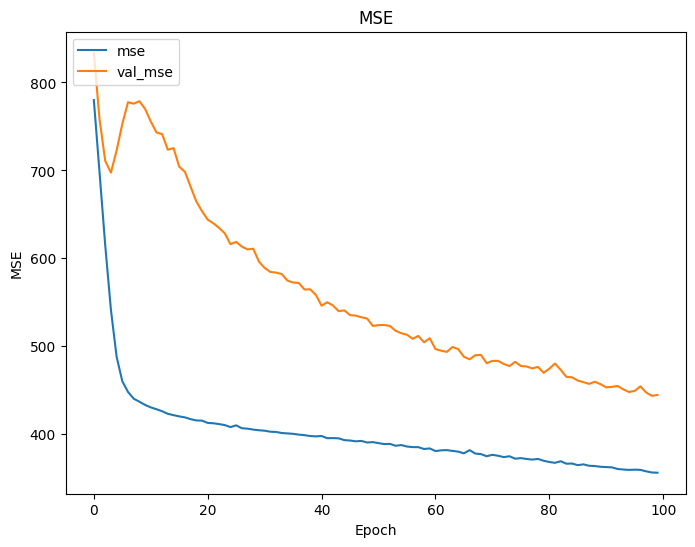

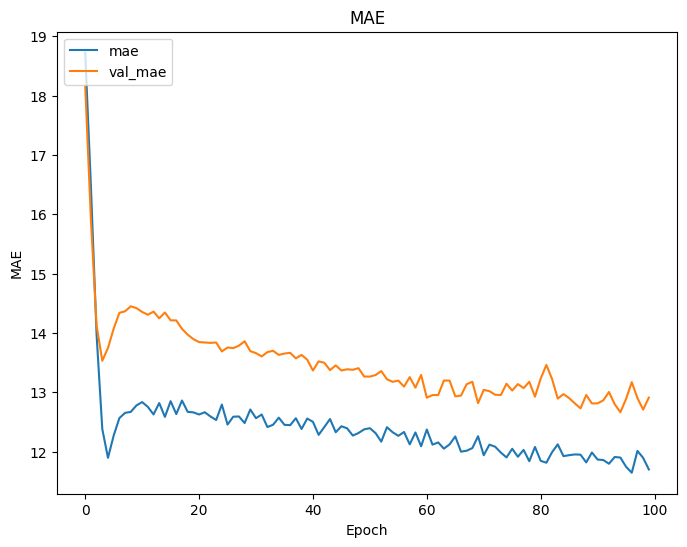

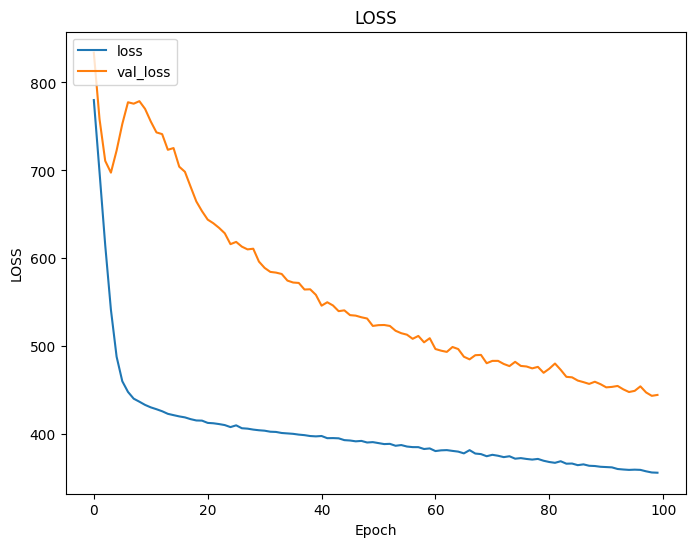

In [66]:
plot_history( history3, plot={'MSE' :['mse', 'val_mse'],
                        'MAE' :['mae', 'val_mae'],
                        'LOSS':['loss','val_loss']}, save_as='history3')

## Step 5 - Restore a model :
### 5.1 - Reload model

In [67]:
loaded_model3 = tf.keras.models.load_model('./run/models/best_model3.h5')
loaded_model3.summary()
print("Loaded.")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_n1 (Dense)            (None, 64)                384       
                                                                 
 Dense_n2 (Dense)            (None, 64)                4160      
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4609 (18.00 KB)
Trainable params: 4609 (18.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Loaded.


### 5.2 - Evaluate it :

In [68]:
score3 = loaded_model3.evaluate(x3_test, y3_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score3[0]))
print('x_test / mae       : {:5.4f}'.format(score3[1]))
print('x_test / mse       : {:5.4f}'.format(score3[2]))

x_test / loss      : 443.6777
x_test / mae       : 12.7068
x_test / mse       : 443.6777


### 5.3 - Make a prediction

In [69]:
# ---- Pick n entries from our test set
n = 50
ii = np.random.randint(1,len(x3_test),n)
x3_sample = x3_test[ii]
y3_sample = y3_test[ii]

In [70]:
# ---- Make a predictions
y3_pred = loaded_model3.predict( x3_sample, verbose=2 )

2/2 - 0s - 18ms/epoch - 9ms/step


In [71]:
# ---- Show it
print('Joueur    Prediction   Real   Delta')
for i in range(n):
    pred   = y3_pred[i][0]
    real   = y3_sample[i]
    delta  = real-pred
    print(f'{i:03d}        {pred:.2f}       {real}      {delta:+.2f} ')

Joueur    Prediction   Real   Delta
000        16.64       25.0      +8.36 
001        15.62       45.0      +29.38 
002        13.41       8.0      -5.41 
003        25.30       80.0      +54.70 
004        32.07       12.0      -20.07 
005        16.41       23.0      +6.59 
006        16.47       9.0      -7.47 
007        16.31       7.0      -9.31 
008        22.87       6.5      -16.37 
009        15.14       10.0      -5.14 
010        22.60       12.0      -10.60 
011        16.17       25.0      +8.83 
012        18.17       20.0      +1.83 
013        15.14       10.0      -5.14 
014        24.40       85.0      +60.60 
015        21.09       22.0      +0.91 
016        16.47       9.0      -7.47 
017        21.61       9.0      -12.61 
018        17.60       70.0      +52.40 
019        18.00       80.0      +62.00 
020        14.12       7.0      -7.12 
021        15.20       12.0      -3.20 
022        22.87       6.5      -16.37 
023        71.13       7.0      -64.13 
02

# Random Forest Model

In [72]:
# let's use data2 defined in "DNN Model avec df2"
data2.head()

Age  Valeur  buts_min_2021  passes_min_2021  buts_min_2022  \
192   24    16.0       0.006775         0.000924       0.004098   
460   28     7.0       0.002045         0.003272       0.003726   
279   26    12.0       0.004545         0.000000       0.000000   
155   25    20.0       0.007167         0.001672       0.002294   
153   30    20.0       0.006847         0.000360       0.005660   

     passes_min_2022  buts_min_total  passes_min_total  
192         0.001025        0.003790          0.001503  
460         0.003726        0.002493          0.001526  
279         0.000000        0.002490          0.002490  
155         0.002294        0.005156          0.001752  
153         0.001887        0.006007          0.000733

In [73]:
# ---- Split => train, test
#
data4       = data2.sample(frac=1., axis=0)     # Shuffle
data4_train = data4.sample(frac=0.8, axis=0)    # get 80 %
data4_test  = data4.drop(data4_train.index)     # test = all - train

# ---- Split => x,y (y is quality)
#
x4_train = data4_train.drop('Valeur', axis=1)
y4_train = data4_train['Valeur']
x4_test  = data4_test.drop('Valeur', axis=1)
y4_test  = data4_test['Valeur']

print('Original data shape was : ',data4.shape)
print('x_train : ',x4_train.shape, 'y_train : ',y4_train.shape)
print('x_test  : ',x4_test.shape,  'y_test  : ',y4_test.shape)

Original data shape was :  (500, 8)
x_train :  (400, 7) y_train :  (400,)
x_test  :  (100, 7) y_test  :  (100,)


In [74]:
regr = RandomForestRegressor(max_depth=7, random_state=0)

In [75]:
regr.fit(x4_train, y4_train)

RandomForestRegressor(max_depth=7, random_state=0)

In [76]:
data4.columns

Index(['Age', 'Valeur', 'buts_min_2021', 'passes_min_2021', 'buts_min_2022',
       'passes_min_2022', 'buts_min_total', 'passes_min_total'],
      dtype='object')

In [77]:
print(regr.feature_importances_)

[0.06028306 0.10002594 0.12417336 0.22211215 0.09746462 0.16394039
 0.23200047]


In [78]:
for name, feature in zip(['Age', 'buts_min_2021', 'passes_min_2021', 'buts_min_2022',
       'passes_min_2022', 'buts_min_total', 'passes_min_total'], regr.feature_importances_):
    print(name, round(feature*100, 1))

Age 6.0
buts_min_2021 10.0
passes_min_2021 12.4
buts_min_2022 22.2
passes_min_2022 9.7
buts_min_total 16.4
passes_min_total 23.2


In [79]:
y_pred = regr.predict(x4_test)

In [80]:
mean_absolute_error(y4_test, y_pred)

11.091755064736772

In [81]:
mean_squared_error(y4_test, y_pred)

216.71162590450652